# Introduction

This notebook conducts [adversarial validation](#https://towardsdatascience.com/adversarial-validation-ca69303543cd).

There have been cases where the test AUC is markedly different to the training AUC. This suggests that there is something fundamentally different in the test set compared to the training set. 

## Summary
* 
* [results of test AUC](#results-of-test-AUC) was an improvement of the [baseline score](#Baseline Score); from 0.69051 to 0.69450

In [45]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

from src.data.make_dataset import load_sets, save_sets, save_predictions, make_adversarial_validation_dataset
from src.models.null import NullModel
from src.visualization.visualize import classification_reports, classification_reports_2
from src.visualization.visualize import plot_pie, create_feature_importance_df, plot_feature_importances


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [4]:
competition = os.environ['COMPETITION']

# Set up directories

In [5]:
project_dir = Path.cwd().parent.parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [10]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')
df_test = pd.read_csv(raw_data_dir / 'test.csv')

In [14]:
target = 'TARGET_5Yrs'

# Baseline

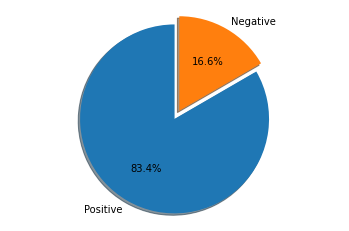

In [15]:
plot_pie(df_train[target])

# Drop columns

ID columns and the original target column is not used in this exercise.

In [16]:
#
df_train.columns

Index(['Id_old', 'Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')

In [19]:
[drop_cols] + [target]

[['Id_old', 'Id'], 'TARGET_5Yrs']

In [20]:
drop_cols = ['Id_old', 'Id'] 
df_train.drop(columns=drop_cols + [target], inplace=True)
df_test.drop(columns=drop_cols, inplace=True)

# Create adversarial data sets

In [24]:
adv_train, adv_test = make_adversarial_validation_dataset(df_train,
                                                          df_test)

In [30]:
target = 'dataset'

In [35]:
y_train = adv_train[target]
X_train = adv_train.drop(columns=target)
y_test = adv_test[target]
X_test = adv_test.drop(columns=target)

In [41]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [49]:
le.classes_

array(['test', 'train'], dtype=object)

# Binary Classification

In [28]:
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [42]:
clf.fit(
    X_train, 
    y_train,
    early_stopping_rounds=10,
    eval_metric='auc',
#     eval_set=[(X_val, y_val)],
    eval_set=[(X_test, y_test)],
       )

[0]	validation_0-auc:0.46953
[1]	validation_0-auc:0.47974
[2]	validation_0-auc:0.48212
[3]	validation_0-auc:0.48058
[4]	validation_0-auc:0.47946
[5]	validation_0-auc:0.48265
[6]	validation_0-auc:0.48445
[7]	validation_0-auc:0.47765
[8]	validation_0-auc:0.47520
[9]	validation_0-auc:0.47765
[10]	validation_0-auc:0.49355
[11]	validation_0-auc:0.49694
[12]	validation_0-auc:0.49761
[13]	validation_0-auc:0.48460
[14]	validation_0-auc:0.47857
[15]	validation_0-auc:0.47652
[16]	validation_0-auc:0.47397
[17]	validation_0-auc:0.47325
[18]	validation_0-auc:0.47118


c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-auc:0.47047
[20]	validation_0-auc:0.46828
[21]	validation_0-auc:0.46497
[22]	validation_0-auc:0.46025


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

 class 1 :  5426
 class 0 :  2574
Confusion Matrix: 
 [[ 238 2336]
 [   8 5418]]
Accuracy:  0.707
AUC:  0.7831875347079917
              precision    recall  f1-score   support

           0       0.97      0.09      0.17      2574
           1       0.70      1.00      0.82      5426

    accuracy                           0.71      8000
   macro avg       0.83      0.55      0.50      8000
weighted avg       0.79      0.71      0.61      8000



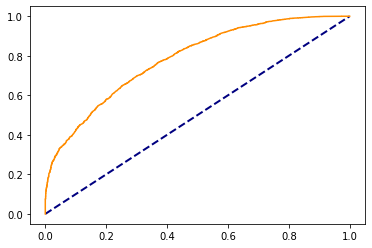

In [43]:
classification_reports(clf, X_train, y_train)

 class 1 :  1744
 class 0 :  411
Confusion Matrix: 
 [[   4  407]
 [  29 1715]]
Accuracy:  0.7976798143851508
AUC:  0.4976094611486863
              precision    recall  f1-score   support

           0       0.12      0.01      0.02       411
           1       0.81      0.98      0.89      1744

    accuracy                           0.80      2155
   macro avg       0.46      0.50      0.45      2155
weighted avg       0.68      0.80      0.72      2155



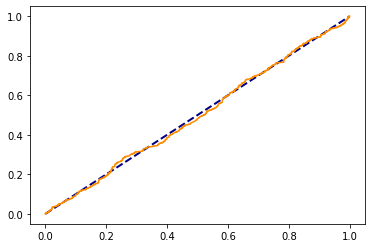

In [44]:
classification_reports(clf, X_test, y_test)